# Kaggle fishery images

In [0]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os, time, json, re
import itertools, collections
import argparse, pickle, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler

import torchvision.transforms as T
import torchvision.transforms.functional as FT
from torchvision import models

from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import error_rate

from PIL import Image as pil_image
import matplotlib.pyplot as plt
import seaborn as sns

## Download data

In [0]:
path = Config.data_path(); path

PosixPath('/root/.fastai/data')

In [0]:
path = '/root/.fastai/data'
if not os.path.exists(path): os.mkdir(path)
os.chdir(path)

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f train.zip

 98% 816M/832M [00:06<00:00, 118MB/s]
100% 832M/832M [00:06<00:00, 127MB/s]


In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f test_stg1.zip

 97% 225M/231M [00:04<00:00, 54.0MB/s]
100% 231M/231M [00:04<00:00, 51.6MB/s]


In [0]:
!unzip -q train.zip

In [0]:
!unzip -q test_stg1.zip

In [0]:
!rm train.zip test_stg1.zip

In [0]:
!rm train/.DS_Store

In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f test_stg2.7z

 99% 1.06G/1.07G [00:18<00:00, 66.4MB/s]
100% 1.07G/1.07G [00:18<00:00, 61.6MB/s]


In [0]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
!p7zip -d test_stg2.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1152137421 bytes (1099 MiB)

Extracting archive: test_stg2.7z
--
Path = test_stg2.7z
Type = 7z
Physical Size = 1152137421
Headers Size = 82081
Method = LZMA:25
Solid = +
Blocks = 1

  0%      0% - test_stg2/image_00001.jpg                                  0% 38 - test_stg2/image_00039.jpg                                     0% 80 - test_stg2/image_00081.jpg                                     1% 125 - test_stg2/image_00126.jpg                                    

## Overview of the images

In [0]:
# train, test_stg1
sum([len(os.listdir(path+'/train/'+c)) for c in os.listdir(path+'/train')]), len(os.listdir(path+'/test_stg1'))

(3777, 1000)

In [0]:
# test_stg2
len(os.listdir(path+'/test_stg2'))

12153

In [0]:
label_clss = os.listdir(path+'/train')
nb_each_class = {c:len(os.listdir(path+'/train/'+c)) for c in label_clss}

In [0]:
nb_each_class

{'ALB': 1719,
 'BET': 200,
 'DOL': 117,
 'LAG': 67,
 'NoF': 465,
 'OTHER': 299,
 'SHARK': 176,
 'YFT': 734}

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


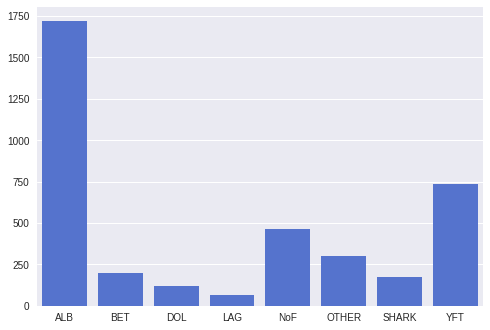

In [0]:
sns.barplot(x=pd.Series(nb_each_class).index, y=pd.Series(nb_each_class).values, color='royalblue');

In [0]:
def read_rand_img(c):
    f = np.random.choice(os.listdir(path+'/train/'+c), 1)[0]
    img = pil_image.open(os.path.join(path,'train',c,f))
    return img

def show_fish(imgs, titles=None, per_row=2):
    if titles:
        assert len(imgs) == len(titles), 'different len between imgs and titles.'
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(16//per_row*cols, 16//per_row*rows))
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())):
        if titles: ax.set_title(titles[i])
        ax.axis('off')
        ax.imshow(img.convert('RGB'))

### See samples in each class

In [0]:
fish_ims = [read_rand_img(c) for c in label_clss]

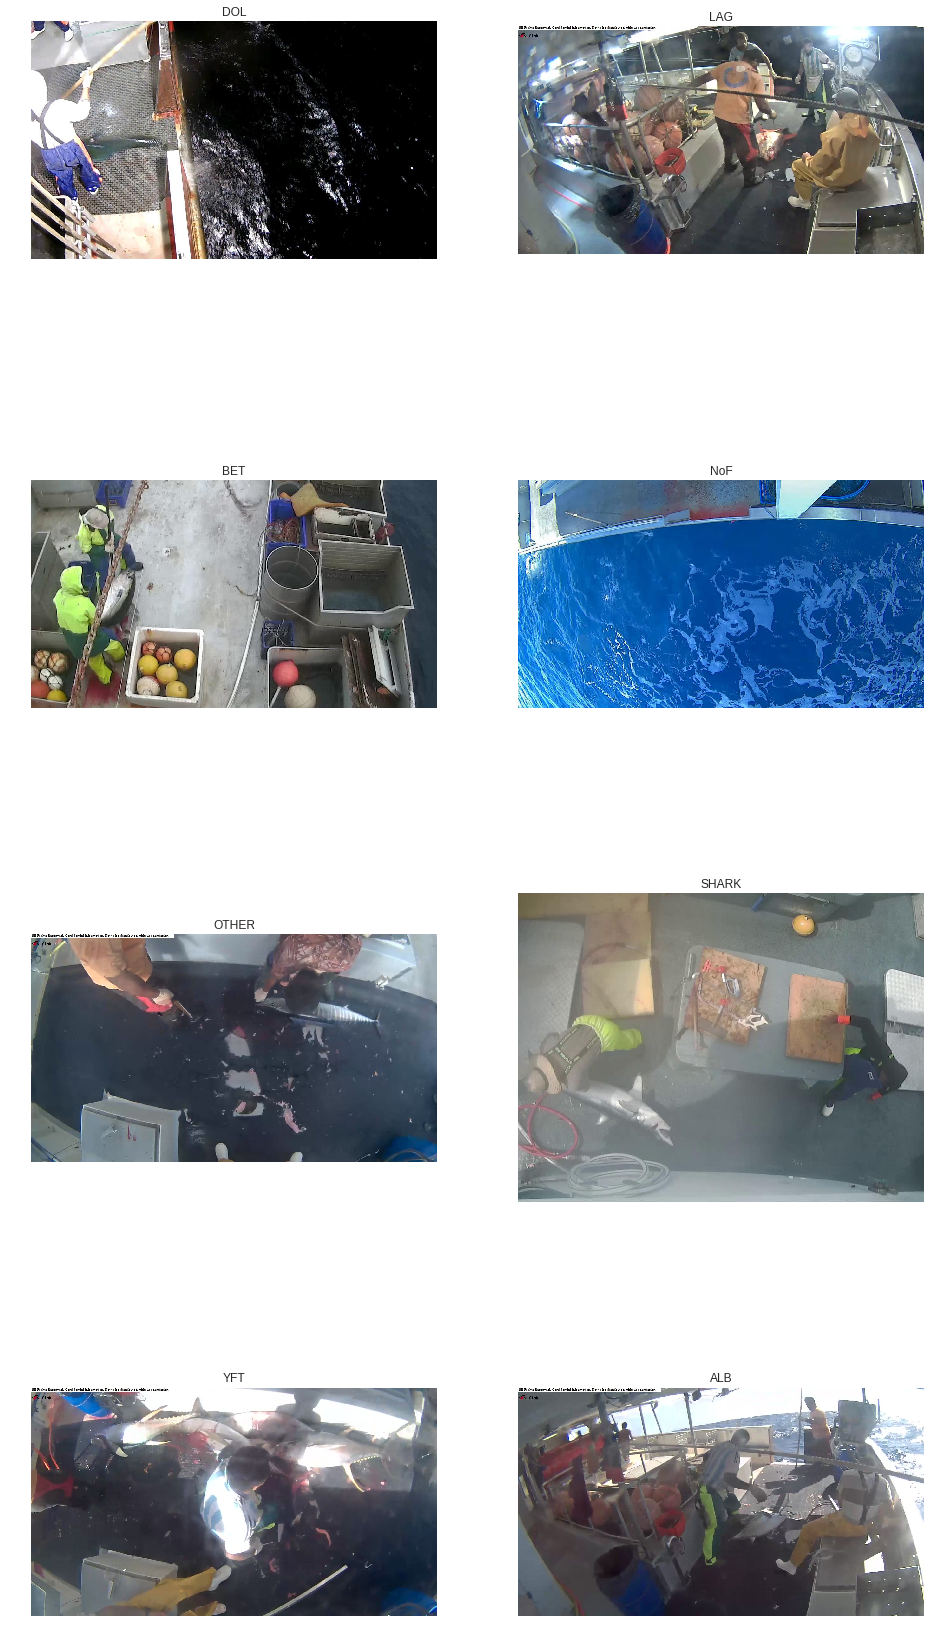

In [0]:
show_fish(fish_ims, label_clss)

### Transformations

In [0]:
def preprocess(img):
    transform = T.Compose([
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        T.RandomHorizontalFlip(),
        T.RandomAffine(degrees=20, shear=20),
        T.Resize((384,384)),
        T.ToTensor(),
                ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.ToPILImage(),
    ])
    return transform(img)

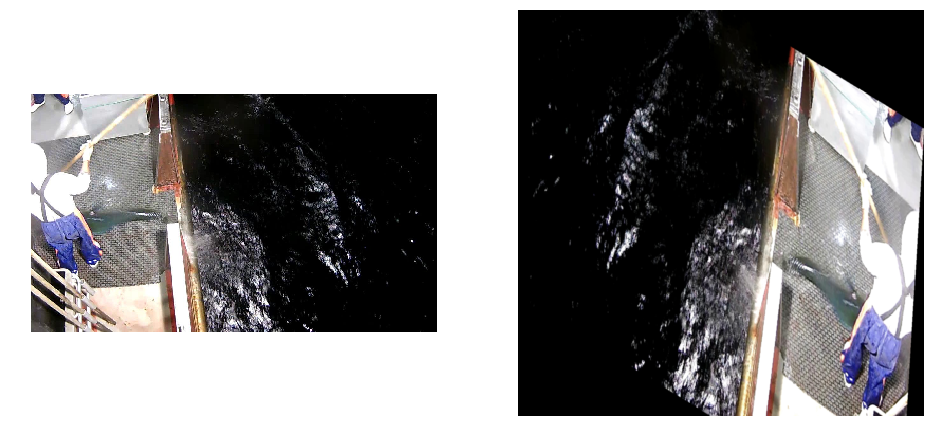

In [0]:
show_fish([fish_ims[0], deprocess(preprocess(fish_ims[0]))])

## Image size (resolution) distribution

In [0]:
%%time
sizes_train_each_c = {c:collections.Counter([pil_image.open(f'{path}/train/{c}/{fn}').size
                      for fn in os.listdir(f"{path}/train/{c}")]) for c in os.listdir(f"{path}/train")}

CPU times: user 291 ms, sys: 40.3 ms, total: 331 ms
Wall time: 330 ms


In [0]:
sizes_train_each_c

{'ALB': Counter({(1192, 670): 164,
          (1244, 700): 2,
          (1276, 718): 109,
          (1280, 720): 1060,
          (1280, 750): 303,
          (1280, 924): 34,
          (1280, 974): 41,
          (1518, 854): 6}),
 'BET': Counter({(1192, 670): 9,
          (1244, 700): 5,
          (1276, 718): 1,
          (1280, 720): 90,
          (1280, 750): 7,
          (1280, 974): 71,
          (1518, 854): 17}),
 'DOL': Counter({(1280, 720): 54, (1280, 750): 24, (1280, 974): 39}),
 'LAG': Counter({(1280, 720): 67}),
 'NoF': Counter({(1192, 670): 23,
          (1244, 700): 13,
          (1276, 718): 95,
          (1280, 720): 190,
          (1280, 750): 64,
          (1334, 750): 31,
          (1518, 854): 14,
          (1732, 974): 35}),
 'OTHER': Counter({(1280, 720): 280, (1280, 750): 10, (1280, 974): 9}),
 'SHARK': Counter({(1280, 720): 103, (1280, 750): 27, (1280, 974): 46}),
 'YFT': Counter({(1192, 670): 2,
          (1244, 700): 7,
          (1276, 718): 15,
          (1280

In [0]:
%%time
im_sizes_train = collections.Counter([pil_image.open(f'{path}/train/{c}/{fn}').size
                        for c in os.listdir(f"{path}/train") for fn in os.listdir(f"{path}/train/{c}")])

CPU times: user 274 ms, sys: 70.2 ms, total: 344 ms
Wall time: 345 ms


In [0]:
im_sizes_train

Counter({(1192, 670): 198,
         (1244, 700): 27,
         (1276, 718): 220,
         (1280, 720): 2174,
         (1280, 750): 598,
         (1280, 924): 60,
         (1280, 974): 395,
         (1334, 750): 31,
         (1518, 854): 39,
         (1732, 974): 35})

In [0]:
%%time
im_sizes_test1 = collections.Counter([pil_image.open(f'{path}/test_stg1/{fn}').size
                        for fn in os.listdir(f"{path}/test_stg1")])

CPU times: user 93.1 ms, sys: 6.72 ms, total: 99.8 ms
Wall time: 99.2 ms


In [0]:
im_sizes_test1

Counter({(1192, 670): 45,
         (1244, 700): 4,
         (1276, 718): 57,
         (1280, 720): 606,
         (1280, 750): 148,
         (1280, 924): 7,
         (1280, 974): 98,
         (1334, 750): 11,
         (1518, 854): 21,
         (1732, 974): 3})

In [0]:
%%time
im_sizes_test2 = collections.Counter([pil_image.open(f'{path}/test_stg2/{fn}').size
                        for fn in os.listdir(f"{path}/test_stg2")])

CPU times: user 901 ms, sys: 235 ms, total: 1.14 s
Wall time: 1.14 s


In [0]:
im_sizes_test2

Counter({(1200, 675): 10477,
         (1208, 755): 1371,
         (1224, 979): 2,
         (1280, 723): 281,
         (1520, 859): 22})

In [0]:
def get_df(sizes_cnts):
    df = pd.DataFrame(list(sizes_cnts.most_common()), columns=['dim', 'count'])
    df['fraction'] = df['count'] / df['count'].sum()
    return df

trn_sz_df = get_df(im_sizes_train)
trn_sz_df['set'] = 'train'
test1_sz_df = get_df(im_sizes_test1)
test1_sz_df['set'] = 'test1'
test2_sz_df = get_df(im_sizes_test2)
test2_sz_df['set'] = 'test2'

In [0]:
trn_sz_df

dim  count  fraction    set
0  (1280, 720)   2174  0.575589  train
1  (1280, 750)    598  0.158327  train
2  (1280, 974)    395  0.104580  train
3  (1276, 718)    220  0.058247  train
4  (1192, 670)    198  0.052423  train
5  (1280, 924)     60  0.015886  train
6  (1518, 854)     39  0.010326  train
7  (1732, 974)     35  0.009267  train
8  (1334, 750)     31  0.008208  train
9  (1244, 700)     27  0.007149  train

In [0]:
test1_sz_df

dim  count  fraction    set
0  (1280, 720)    606     0.606  test1
1  (1280, 750)    148     0.148  test1
2  (1280, 974)     98     0.098  test1
3  (1276, 718)     57     0.057  test1
4  (1192, 670)     45     0.045  test1
5  (1518, 854)     21     0.021  test1
6  (1334, 750)     11     0.011  test1
7  (1280, 924)      7     0.007  test1
8  (1244, 700)      4     0.004  test1
9  (1732, 974)      3     0.003  test1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


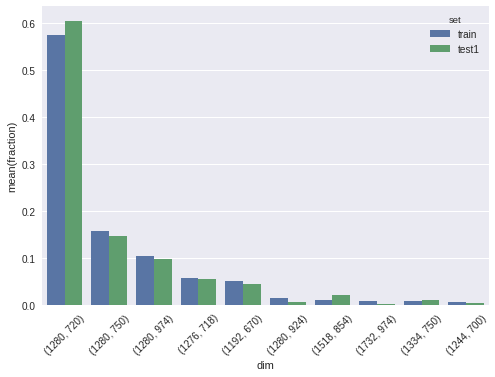

In [0]:
cat_df = pd.concat([trn_sz_df, test1_sz_df])
sns.barplot(x='dim',y='fraction',data=cat_df, hue="set")
_ = plt.xticks(rotation=45)

In [0]:
trn_test1_sz_df = trn_sz_df.merge(test1_sz_df, how='outer', on='dim')
trn_test1_sz_df['count'] = trn_test1_sz_df['count_x'] + trn_test1_sz_df['count_y']
trn_test1_sz_df['fraction'] = trn_test1_sz_df['count'] / trn_test1_sz_df['count'].sum()
trn_test1_sz_df = trn_test1_sz_df[['dim', 'count', 'fraction']]
trn_test1_sz_df

dim  count  fraction
0  (1280, 720)   2780  0.581955
1  (1280, 750)    746  0.156165
2  (1280, 974)    493  0.103203
3  (1276, 718)    277  0.057986
4  (1192, 670)    243  0.050869
5  (1280, 924)     67  0.014026
6  (1518, 854)     60  0.012560
7  (1732, 974)     38  0.007955
8  (1334, 750)     42  0.008792
9  (1244, 700)     31  0.006489

## Check bounding box

In [0]:
path = '/content/drive/My Drive/DL_projects/Data/fish_monitor'

In [0]:
os.listdir(path+'/fish_bbox')

['alb_labels.json',
 'dol_labels.json',
 'yft_labels.json',
 'other_labels.json',
 'bet_labels.json',
 'lag_labels.json',
 'shark_labels.json']

In [0]:
gt = {}
for c in ['DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']:
    with open(os.path.join(path, 'fish_bbox', c.lower()+'_labels.json')) as f:
        gt[c] = json.load(f)

In [0]:
cls = 'DOL'
fname = np.random.choice(os.listdir(path+'/train/'+c), 1)[0]
mask = list(map(lambda x: x['filename'].split('/')[-1]==fname, gt[cls]))
bb = np.array(gt[c])[mask][0]['annotations']

In [0]:
bb

[{'class': 'rect',
  'height': 202.0000000000005,
  'width': 166.0000000000004,
  'x': 286.0000000000007,
  'y': 282.0000000000007}]

In [0]:
from PIL.ImageDraw import Draw

im = pil_image.open(os.path.join(path, 'train', c, fname))
im_o = im.copy()
draw = Draw(im)
for i in range(len(bb)):
    draw.rectangle([bb[i]['x'], bb[i]['y'], bb[i]['x']+bb[i]['width'], bb[i]['y']+bb[i]['height']], outline='red')

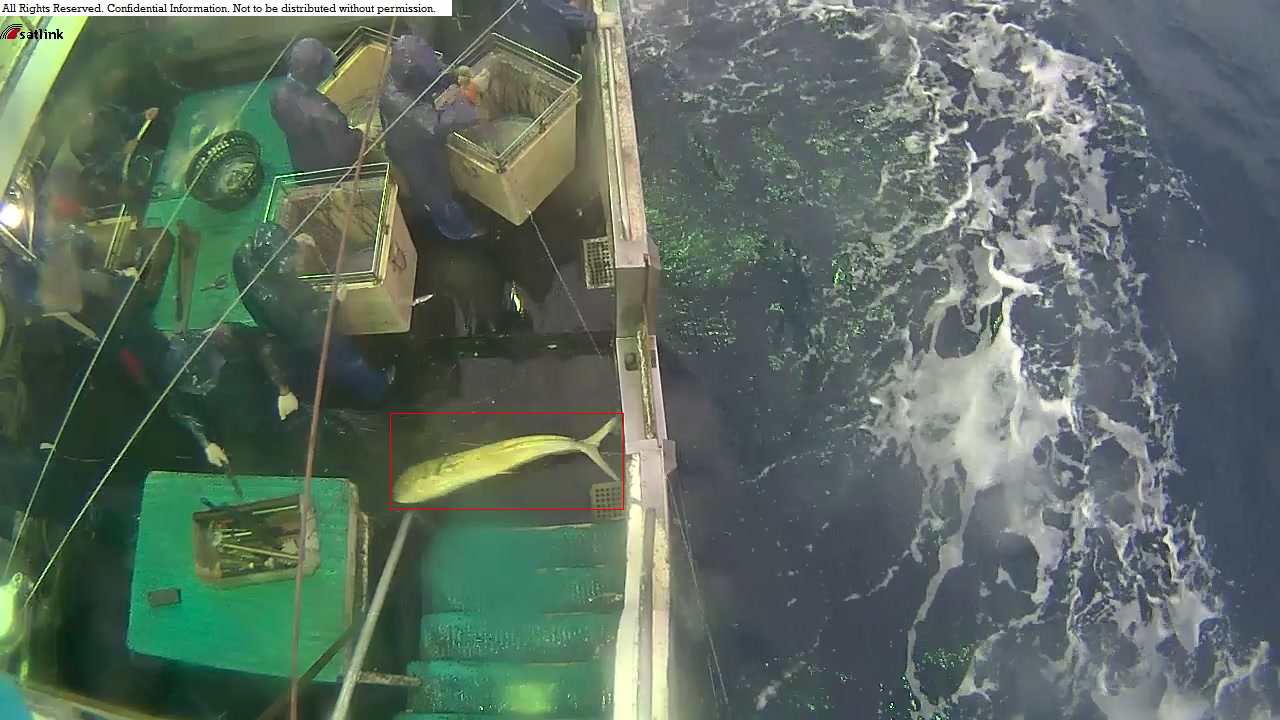

In [0]:
im

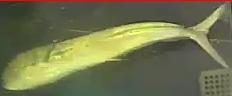

In [0]:
im.crop([bb[0]['x'], bb[0]['y'], bb[0]['x']+bb[0]['width'], bb[0]['y']+bb[0]['height']])

There are some images in some categories are not labelled yet.

In [0]:
no_bb_file_idxs = {}
for c in ['DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']:
    im_files = os.listdir(os.path.join(path, 'train', c))
    no_bb_idx = []
    for i, fname in enumerate(im_files):
        mask = list(map(lambda x: x['filename'].split('/')[-1]==fname, gt[c]))
        bb = np.array(gt[c])[mask][0]['annotations']
        if len(bb) == 0:
            no_bb_idx.append(i)
    no_bb_file_idxs[c] = list(np.array(im_files)[no_bb_idx])

no_bb_file_idxs

{'ALB': ['img_00568.jpg',
  'img_01958.jpg',
  'img_07008.jpg',
  'img_00425.jpg',
  'img_04798.jpg',
  'img_06460.jpg',
  'img_02292.jpg',
  'img_00576.jpg'],
 'BET': ['img_00379.jpg'],
 'DOL': ['img_06773.jpg', 'img_05444.jpg'],
 'LAG': [],
 'OTHER': [],
 'SHARK': ['img_06082.jpg'],
 'YFT': ['img_03183.jpg', 'img_04558.jpg', 'img_02785.jpg']}

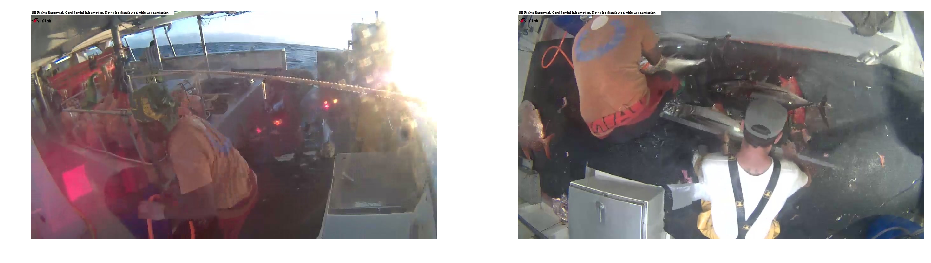

In [0]:
imgs = []
imgs.append(pil_image.open(os.path.join(path,'train/BET/img_00379.jpg')))
imgs.append(pil_image.open(os.path.join(path,'train/SHARK/img_06082.jpg')))

show_fish(imgs)

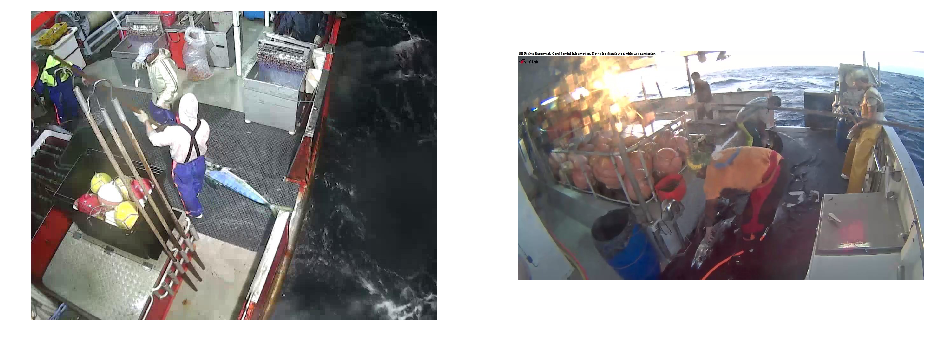

In [0]:
c = 'DOL'
imgs = []
for f in no_bb_file_idxs[c]:
    imgs.append(pil_image.open(os.path.join(path,'train',c,f)))

show_fish(imgs)

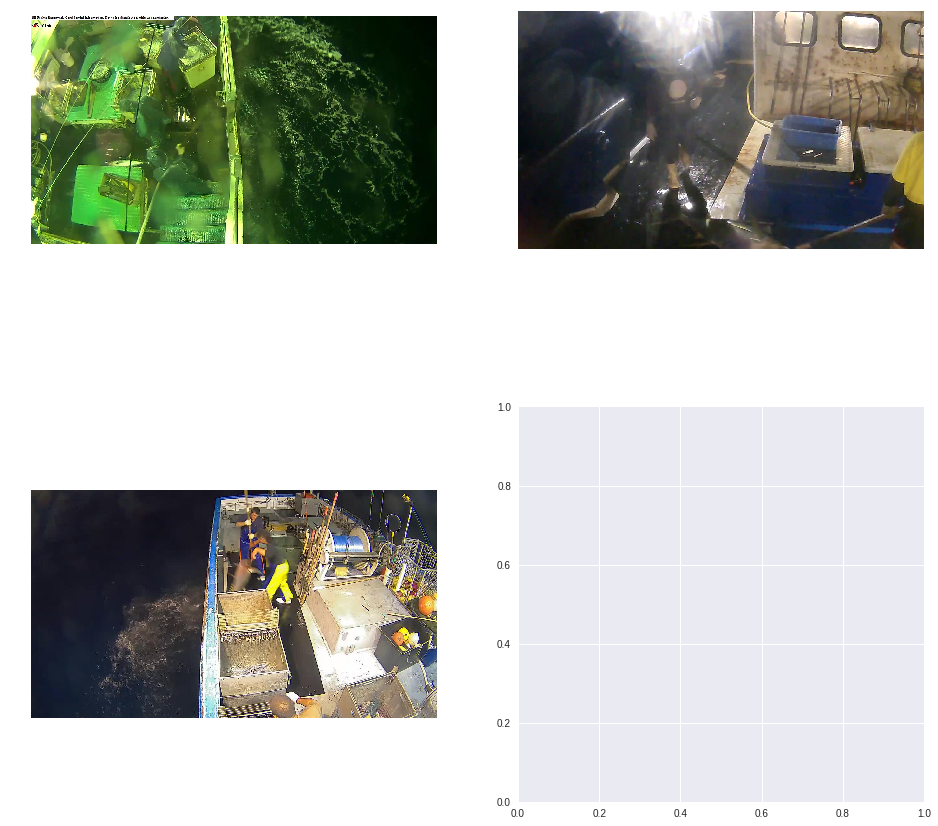

In [0]:
c = 'YFT'
imgs = []
for f in no_bb_file_idxs[c]:
    imgs.append(pil_image.open(os.path.join(path,'train',c,f)))

show_fish(imgs)

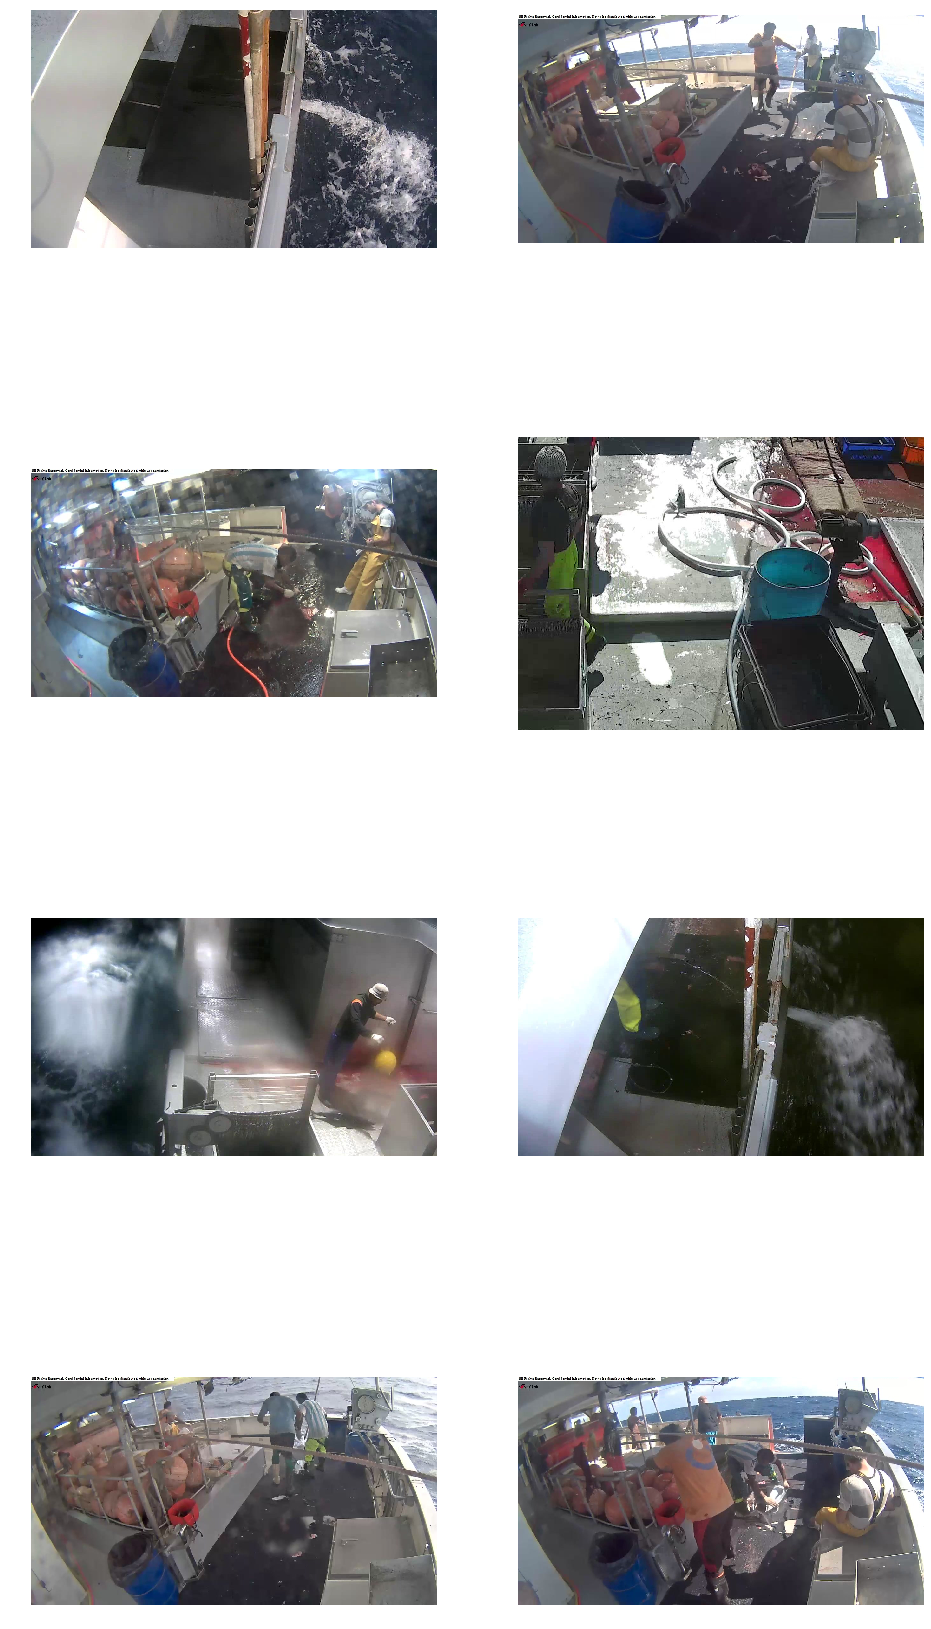

In [0]:
c = 'ALB'
imgs = []
for f in no_bb_file_idxs[c]:
    imgs.append(pil_image.open(os.path.join(path,'train',c,f)))

show_fish(imgs)

### before vs after transformation

In [0]:
# Augmentation functions (with bbox) adapted from
# https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)


def expand(image, boxes, filler):
    """
    Perform a zooming out operation by placing the image in a larger canvas of filler material.

    Helps to learn to detect smaller objects.

    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param filler: RBG values of the filler material, a list like [R, G, B]
    :return: expanded image, updated bounding box coordinates
    """
    # Calculate dimensions of proposed expanded (zoomed-out) image
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    # Create such an image with the filler
    filler = torch.FloatTensor(filler)  # (3)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)  # (3, new_h, new_w)
    # Note - do not use expand() like new_image = filler.unsqueeze(1).unsqueeze(1).expand(3, new_h, new_w)
    # because all expanded values will share the same memory, so changing one pixel will change all

    # Place the original image at random coordinates in this new image (origin at top-left of image)
    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    # Adjust bounding boxes' coordinates accordingly
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(
        0)  # (n_objects, 4), n_objects is the no. of objects in this image

    return new_image, new_boxes


def random_crop(image, boxes):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.

    Note that some objects may be cut out entirely.

    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py

    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum overlap
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes

        # Try up to 50 times for this choice of minimum overlap
        # This isn't mentioned in the paper, of course, but 50 is chosen in paper authors' original Caffe repo
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0),
                                           boxes)  # (1, n_objects), n_objects is the no. of objects in this image
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes


def flip(image, boxes):
    """
    Flip image horizontally.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes


def resize(image, boxes, dims=(300, 300), return_percent_coords=True):
    """
    Resize image. For the SSD300, resize to (300, 300).

    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes / old_dims  # percent coordinates

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes


def photometric_distort(image):
    """
    Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.

    :param image: image, a PIL Image
    :return: distorted image
    """
    new_image = image

    distortions = [FT.adjust_brightness,
                   FT.adjust_contrast,
                   FT.adjust_saturation,
                   FT.adjust_hue]

    random.shuffle(distortions)

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is 'adjust_hue':
                # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:
                # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
                adjust_factor = random.uniform(0.5, 1.5)

            # Apply this distortion
            new_image = d(new_image, adjust_factor)

    return new_image


def transform(image, boxes):
    """
    Apply the transformations above.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: transformed image, transformed bounding box coordinates, transformed labels
    """
    new_image = image
    new_boxes = boxes
    
    # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
    new_image = photometric_distort(new_image)

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
    # Fill surrounding space with the mean of ImageNet data that our base VGG was trained on
    if random.random() < 0.5:
        new_image, new_boxes = expand(new_image, boxes, filler=mean)

    # Randomly crop image (zoom in)
    new_image, new_boxes = random_crop(new_image, new_boxes)

    # Convert Torch tensor to PIL image
    new_image = FT.to_pil_image(new_image)

    # Flip image with a 50% chance
    if random.random() < 0.5:
        new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (300, 300) - this also converts point coordinates to fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    return new_image, new_boxes

In [0]:
im = pil_image.open(os.path.join(path, 'train', c, fname))
im_o = im.copy()

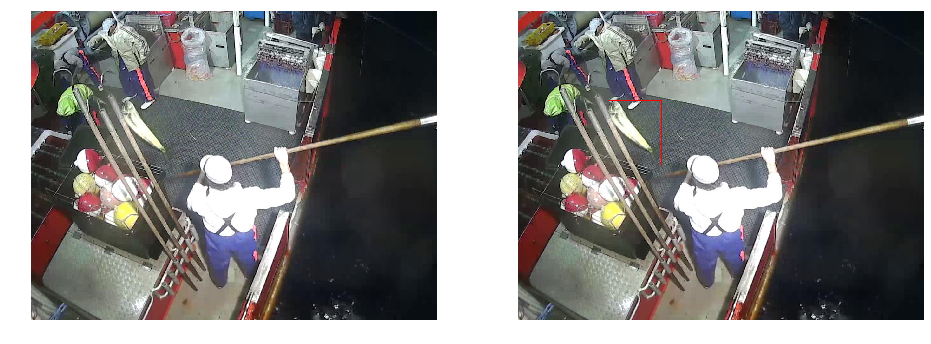

In [0]:
# before transformation
show_fish([im_o, im])

In [0]:
bboxes = np.array([[bb[i]['x'], bb[i]['y'], bb[i]['x']+bb[i]['width'], bb[i]['y']+bb[i]['height']] for i in range(len(bb))])

In [0]:
bboxes, im_o.size

(array([[286., 282., 452., 484.]]), (1280, 974))

In [0]:
new_im, new_bb = transform(im_o, torch.FloatTensor(bboxes))

In [0]:
new_bb.numpy()[0]

array([0.279678, 0.393293, 0.613682, 0.701219], dtype=float32)

In [0]:
w,h = new_im.size
new_im_o = new_im.copy()
new_bb = new_bb.numpy()
draw = Draw(new_im)
for i in range(len(new_bb)):
    draw.rectangle([int(new_bb[i][0]*w), int(new_bb[i][1]*h), int(new_bb[i][2]*w), int(new_bb[i][3]*h)], outline='red')

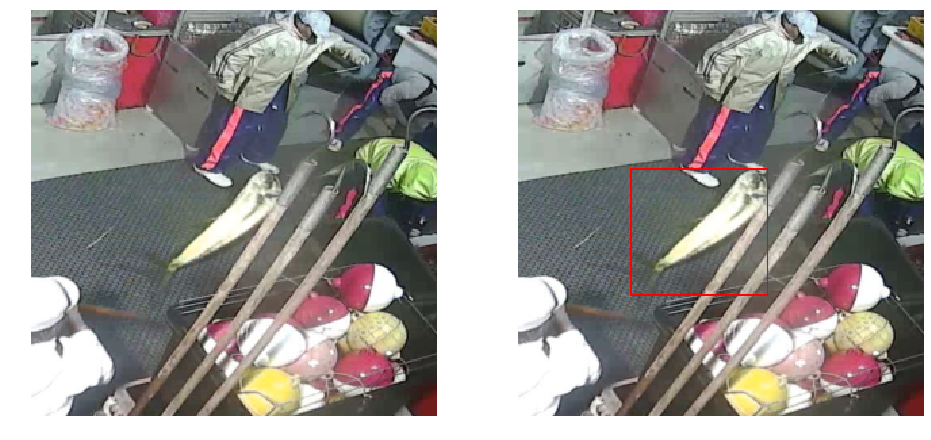

In [0]:
# after transformation
show_fish([new_im_o, new_im])